In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn import metrics
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

def get_remote_dataset(URL,header=None):
    try:
        path = get_file(URL.split('/')[-1], origin=URL)
    except:
        print('Error downloading remote dataset.')
        raise
    return pd.read_csv(path, header=header)

def get_local_dataset(PATH, header=None):
    try:
        df = pd.read_csv(PATH,header=header)
    except:
        print('Error loading local dataset.')
        raise
    df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)
    print('Read {} rows.'.format(len(df)))
    return df

def set_KDD_columns(kdd_df):
    kdd_df.columns = [
        'duration',
        'protocol_type',
        'service',
        'flag',
        'src_bytes',
        'dst_bytes',
        'land',
        'wrong_fragment',
        'urgent',
        'hot',
        'num_failed_logins',
        'logged_in',
        'num_compromised',
        'root_shell',
        'su_attempted',
        'num_root',
        'num_file_creations',
        'num_shells',
        'num_access_files',
        'num_outbound_cmds',
        'is_host_login',
        'is_guest_login',
        'count',
        'srv_count',
        'serror_rate',
        'srv_serror_rate',
        'rerror_rate',
        'srv_rerror_rate',
        'same_srv_rate',
        'diff_srv_rate',
        'srv_diff_host_rate',
        'dst_host_count',
        'dst_host_srv_count',
        'dst_host_same_srv_rate',
        'dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate',
        'dst_host_serror_rate',
        'dst_host_srv_serror_rate',
        'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate',
        'outcome',
        'difficulty_rating'
    ]
    #return kdd_df

def set_bin_class(df):
    for i, row in df.iterrows():
        if row['outcome'].split('.')[0] != 'normal':
            df.at[i, 'outcome'] = 'anomaly'

def set_multi_class(df):
    ### THIS WILL ONLY WORK WITH THE ENTIRE KDD DATASET. WILL NOT WORK WITH NSL-KDD SET!!! ###
    ### THIS IS YOUR ONLY WARNING!!!###
    DOS_TYPES = ('back','land','neptune','pod','smurf','teardrop')
    U2R_TYPES = ('buffer_overflow','loadmodule','perl','rootkit')
    R2L_TYPES = ('ftp_write','guess_passwd','imap','multihop','phf','spy','warezclient','warezmaster')
    PROBE_TYPES = ('ipsweep','nmap','portsweep','satan')
            
    for i, row in df.iterrows():
        val = 'normal'
        old_val = row['outcome'].split('.')[0]
        if old_val in DOS_TYPES:
            val = 'dos'
        elif old_val in U2R_TYPES:
            val = 'u2r'
        elif old_val in R2L_TYPES:
            val = 'r2l'
        elif old_val in PROBE_TYPES:
            val = 'probe'
        df.at[i,'outcome'] = val 

def encode_zscore(df, name, mean=None, std_dev=None):
    '''Encode numeric values as zscore'''
    if mean == None:
        mean = df[name].mean()
    if std_dev == None:
        std_dev = df[name].std()
    df[name] = (df[name] - mean) / std_dev

def encode_text(df, name):
    '''Encode text values to binary dummy values (i.e. red,blue is [0,1] or [1,0])'''
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        new_name = f"{name}-{x}"
        df[new_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

def reencode_dataset(df):
    '''Takes a KDD pandas dataframe and transforms the data by 
    changing numeric columns to zscore, and text columns to 
    dummy values'''

    encode_zscore(df, 'duration')
    encode_text(df, 'protocol_type')
    encode_text(df, 'service')
    encode_text(df, 'flag')
    encode_zscore(df, 'src_bytes')
    encode_zscore(df, 'dst_bytes')
    encode_text(df, 'land')
    encode_zscore(df, 'wrong_fragment')
    encode_zscore(df, 'urgent')
    encode_zscore(df, 'hot')
    encode_zscore(df, 'num_failed_logins')
    encode_text(df, 'logged_in')
    encode_zscore(df, 'num_compromised')
    encode_zscore(df, 'root_shell')
    encode_zscore(df, 'su_attempted')
    encode_zscore(df, 'num_root')
    encode_zscore(df, 'num_file_creations')
    encode_zscore(df, 'num_shells')
    encode_zscore(df, 'num_access_files')
    encode_zscore(df, 'num_outbound_cmds')
    encode_text(df, 'is_host_login')
    encode_text(df, 'is_guest_login')
    encode_zscore(df, 'count')
    encode_zscore(df, 'srv_count')
    encode_zscore(df, 'serror_rate')
    encode_zscore(df, 'srv_serror_rate')
    encode_zscore(df, 'rerror_rate')
    encode_zscore(df, 'srv_rerror_rate')
    encode_zscore(df, 'same_srv_rate')
    encode_zscore(df, 'diff_srv_rate')
    encode_zscore(df, 'srv_diff_host_rate')
    encode_zscore(df, 'dst_host_count')
    encode_zscore(df, 'dst_host_srv_count')
    encode_zscore(df, 'dst_host_same_srv_rate')
    encode_zscore(df, 'dst_host_diff_srv_rate')
    encode_zscore(df, 'dst_host_same_src_port_rate')
    encode_zscore(df, 'dst_host_srv_diff_host_rate')
    encode_zscore(df, 'dst_host_serror_rate')
    encode_zscore(df, 'dst_host_srv_serror_rate')
    encode_zscore(df, 'dst_host_rerror_rate')
    encode_zscore(df, 'dst_host_srv_rerror_rate')

    #return df

def generate_training_set(df, num_outcomes,frac=0.1):
    '''This doesn't work well right now. FIX ME!!!'''
    while True:
        df_train = df.sample(frac=frac, replace=False)
        dummies = pd.get_dummies(df_train['outcome'])
        if len(dummies.columns) != num_outcomes:
            continue
        x_columns = df_train.columns.drop(['outcome','difficulty_rating'])
        x = df_train[x_columns].values
        y = dummies.values
        break

    print(df_train.groupby('outcome')['outcome'].count())
    print(df_train.head())
    print(df_train.columns)

    return x, y

def build_classifier(x, y, hidden_layers=[8], activation='relu', batch_size=None, verbose=1):
    def baseline_model():
        model = Sequential()
        for layer in hidden_layers:
            model.add(Dense(layer, activation=activation))
        model.add(Dense(y.shape[1], activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    estimator = KerasClassifier(build_fn=baseline_model, batch_size=batch_size, verbose=verbose)
    return estimator

def run_tf():
    ###acquire and process dataset
    df = get_local_dataset('./nslkdd/KDDTest+.txt')
    #df_train = get_local_dataset('./nslkdd/KDDTrain+.txt')
    set_KDD_columns(df)
    reencode_dataset(df)
    #set_bin_class(df)
    df.dropna(inplace=True, axis=1)
    x, y = generate_training_set(df,df['outcome'].nunique(),frac=1.0)

    ###build MLP model
    estimator = build_classifier(x, y, hidden_layers=[64,64])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

    ###train model
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    estimator.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=1,epochs=100)

    ###evaluate model
    pred = estimator.predict(x_test)
    y_eval = np.argmax(y_test, axis=1)
    print(y_eval)
    score = metrics.accuracy_score(y_eval, pred)
    print("Validation score: {}".format(score))

def run_tf_full():
    df_test = get_local_dataset('./nslkdd/KDDTest+.txt')
    set_KDD_columns(df_test)
    reencode_dataset(df_test)
    set_bin_class(df_test)
    for col in ('service-aol','service-harvest','service-http_2784','service-http_8001','service-red_i','service-urh_i'):
        df_test[col] = 0    
    df_test.fillna(value=0, inplace=True, axis=1)

    x_final, y_final = generate_training_set(df_test, df_test['outcome'].nunique(), frac=1.0)
    
    df_train = get_local_dataset('./nslkdd/KDDTrain+.txt')
    set_KDD_columns(df_train)
    reencode_dataset(df_train)
    set_bin_class(df_train)
    df_train.fillna(value=0, inplace=True, axis=1)

    df_test = df_test[df_train.columns] #fixes column ordering (does that matter? probably)
    #print(df_test.columns)
    #print(df_train.columns)
    
    x, y = generate_training_set(df_train, df_train['outcome'].nunique(), frac=0.1)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)


    #for col in df_train.columns:
    #    if col not in df_test.columns:
    #        print(col)

    estimator = build_classifier(x_train, y_train, hidden_layers=[128,128,128,128,128,128,128,128,128,128])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
    
    estimator.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=1,epochs=100)

    ###evaluate model
    pred = estimator.predict(x_final)
    y_eval = np.argmax(y_final, axis=1)
    print(y_eval)
    score = metrics.accuracy_score(y_eval, pred)
    print("Validation score: {}".format(score))

def run_sklearn():
    df = get_local_dataset('./nslkdd/KDDTrain+.txt')
    df = set_KDD_columns(df)
    df = reencode_dataset(df)
    df.dropna(inplace=True, axis=1)
    x, y = generate_training_set(df,df['outcome'].nunique())

    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=42)

    mlp = MLPClassifier(hidden_layer_sizes=(64,64,),max_iter=50,verbose=True)
    mlp.fit(x_train, y_train)

    predictions = mlp.predict(x_test)
    #print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test,predictions))

In [76]:
from sklearn.cluster import KMeans

#df = get_local_dataset('./nslkdd/KDDTrain+.txt')
df = get_local_dataset('./nslkdd/KDDTest+.txt')
print(len(df))
complete_df = df
set_KDD_columns(df)
#set_KDD_columns(df2)
#set_bin_class(df)
control = df
reencode_dataset(df)
#reencode_dataset(df2)

df.dropna(inplace=True, axis=1)

x, y = generate_training_set(df,df['outcome'].nunique(), frac=1.0)
#x2, y2 = generate_training_set(df2, df2['outcome'].nunique(), frac=1.0)

todrop = []
for outcome in df2['outcome'].unique():
    if outcome not in df['outcome'].unique():
        todrop.append(outcome)

#print(len(df2))
#for col in todrop:
#    df2.drop(col, axis=1, inplace=True)
#print(len(df2))
#model = KMeans().fit(x)


Read 22544 rows.
22544
outcome
apache2             737
back                359
buffer_overflow      20
ftp_write             3
guess_passwd       1231
httptunnel          133
imap                  1
ipsweep             141
land                  7
loadmodule            2
mailbomb            293
mscan               996
multihop             18
named                17
neptune            4657
nmap                 73
normal             9711
perl                  2
phf                   2
pod                  41
portsweep           157
processtable        685
ps                   15
rootkit              13
saint               319
satan               735
sendmail             14
smurf               665
snmpgetattack       178
snmpguess           331
sqlattack             2
teardrop             12
udpstorm              2
warezmaster         944
worm                  2
xlock                 9
xsnoop                4
xterm                13
Name: outcome, dtype: int64
       duration  src_bytes  d

In [77]:
# import seaborn as sns
# sns.set(style='ticks')

# fig = sns.pairplot(df, vars = [], hue='outcome', height=2, aspect=1, dropna=True)

In [78]:
df.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_host_login-1,is_guest_login-0,is_guest_login-1
count,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,2.254400e+04,...,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000
mean,2.269299e-17,3.151804e-19,6.146018e-18,1.765010e-17,-6.303608e-19,-5.673248e-18,-4.097345e-18,-3.151804e-19,2.316576e-17,-5.673248e-18,...,0.659821,0.003238,0.999689,0.000311,0.557798,0.442202,0.999512,0.000488,0.971567,0.028433
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.473780,0.056813,0.017619,0.017619,0.496659,0.496659,0.022084,0.022084,0.166211,0.166211
min,-1.555306e-01,-2.198762e-02,-9.689382e-02,-5.910263e-02,-1.945882e-02,-1.135186e-01,-1.439958e-01,-1.649319e-02,-4.945232e-02,-1.263749e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.555306e-01,-2.198762e-02,-9.689382e-02,-5.910263e-02,-1.945882e-02,-1.135186e-01,-1.439958e-01,-1.649319e-02,-4.945232e-02,-1.263749e-02,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,-1.555306e-01,-2.187341e-02,-9.472598e-02,-5.910263e-02,-1.945882e-02,-1.135186e-01,-1.439958e-01,-1.649319e-02,-4.945232e-02,-1.263749e-02,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,-1.555306e-01,-2.138058e-02,-6.857055e-02,-5.910263e-02,-1.945882e-02,-1.135186e-01,-1.439958e-01,-1.649319e-02,-4.945232e-02,-1.263749e-02,...,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,4.085922e+01,1.328618e+02,6.333249e+01,2.097894e+01,8.223296e+01,1.086725e+02,2.646453e+01,1.094806e+02,2.022060e+01,9.495388e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [79]:
y[3553]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [80]:
pd.set_option('display.max_rows', 200)
print(df.dtypes)

duration                       float64
src_bytes                      float64
dst_bytes                      float64
wrong_fragment                 float64
urgent                         float64
hot                            float64
num_failed_logins              float64
num_compromised                float64
root_shell                     float64
su_attempted                   float64
num_root                       float64
num_file_creations             float64
num_shells                     float64
num_access_files               float64
count                          float64
srv_count                      float64
serror_rate                    float64
srv_serror_rate                float64
rerror_rate                    float64
srv_rerror_rate                float64
same_srv_rate                  float64
diff_srv_rate                  float64
srv_diff_host_rate             float64
dst_host_count                 float64
dst_host_srv_count             float64
dst_host_same_srv_rate   

In [81]:
from sklearn.preprocessing import StandardScaler

df['outcome'].head()

0    neptune
1    neptune
2     normal
3      saint
4      mscan
Name: outcome, dtype: object

In [82]:
x_df = df.drop(['outcome'], axis=1)

In [83]:
x_df = StandardScaler().fit_transform(x_df)

In [84]:
x_df[:10]

array([[-1.55534087e-01, -2.19881116e-02, -9.68959693e-02, ...,
        -2.20946351e-02,  1.71071323e-01, -1.71071323e-01],
       [-1.55534087e-01, -2.19881116e-02, -9.68959693e-02, ...,
        -2.20946351e-02,  1.71071323e-01, -1.71071323e-01],
       [-1.54112770e-01,  5.47309946e-03, -9.68959693e-02, ...,
        -2.20946351e-02,  1.71071323e-01, -1.71071323e-01],
       ...,
       [-1.55534087e-01, -2.17152551e-02, -8.86957045e-02, ...,
        -2.20946351e-02,  1.71071323e-01, -1.71071323e-01],
       [-1.55534087e-01, -2.12964520e-02, -7.48872126e-02, ...,
        -2.20946351e-02,  1.71071323e-01, -1.71071323e-01],
       [-1.55534087e-01, -2.19331172e-02, -8.94968798e-02, ...,
        -2.20946351e-02, -5.84551510e+00,  5.84551510e+00]])

In [140]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_df)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])



In [115]:
len(principalDf)
principalDf[:3]

,principal component 1,principal component 2
0,1.629281,-0.956724
1,1.608832,-0.956847
2,-0.343801,0.079323


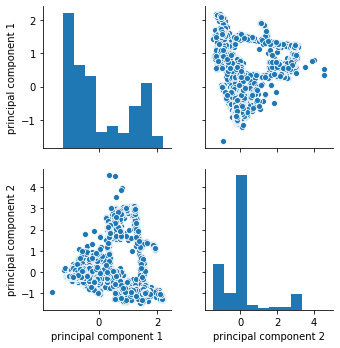

In [116]:
import seaborn as sns
g = sns.pairplot(principalDf)

In [117]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 2)
km.fit(principalDf)
y_kmeans = km.predict(principalDf)

In [118]:
#this block prepares a true_normal_df for visualization, so we can compare against the two groups generated by K-Means Clustering
true_normal_df = principalDf.copy() #get the PCA1 and PCA2 columns from the principalDf (original df), copy them into a new true_normal_df
true_normal_df['outcome'] = df['outcome'] #copy the outcome column from the original dataframe to the true_normal_df
true_normal_df = true_normal_df.drop(true_normal_df[true_normal_df.outcome != 'normal'].index) #delete all rows from the true_normal_df that have an outcome that is NOT normal
print(len(true_normal_df['outcome']), (true_normal_df.outcome == 'normal').sum()) #proof that every outcome in our table is normal
true_normal_df.drop(['outcome'], axis = 1) #finally, drop the outcome column from the true_normal_df, and we are left with PCA1 and PCA2 cols that correspond to the true normal rows, so we can plot and visualize these in the next step

9711 9711


,principal component 1,principal component 2
2,-0.343801,0.079323
5,-0.936762,-0.163044
6,-0.170056,-0.391377
8,-0.926862,-0.166817
11,-0.564283,-0.293423
...,...,...
22533,-0.965184,-0.175662
22535,-1.015059,-0.180424
22539,-0.728394,-0.150484
22540,-0.914477,-0.171819


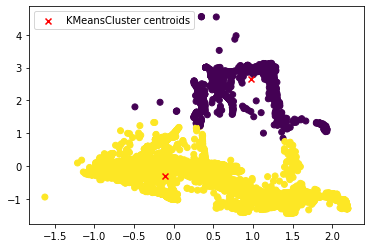

In [119]:
import matplotlib.pyplot as plt

scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c = y_kmeans, cmap = 'viridis')
centers = np.array(km.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r', label = 'KMeansCluster centroids')
plt.legend(loc="upper left")
# Below we see the result of splitting the dataset into 2 clusters using KMeans Clusters.
# On the left is normal data, on the right is anomaly data

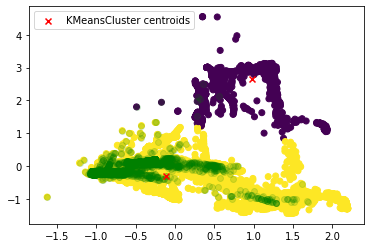

In [120]:
import matplotlib.pyplot as plt

scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c = y_kmeans, cmap = 'viridis')
centers = np.array(km.cluster_centers_)
plt.scatter(true_normal_df['principal component 1'], true_normal_df['principal component 2'], color = 'g', alpha = 0.15)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r', label = 'KMeansCluster centroids')
plt.legend(loc="upper left")
# Below we see the result of splitting the dataset into 2 clusters using KMeans Clusters.
# On the left is normal data, on the right is anomaly data
# We can confirm that the left is normal data by overlaying it with the values found in true_normal_df

In [141]:
y_kmeans

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [121]:
print(km.cluster_centers_)


[[ 0.97946211  2.64958571]
 [-0.11079582 -0.2997186 ]]


In [122]:
print('actual percentage of outcome classified as normal', (df.outcome == 'normal').sum() / len(df['outcome']), '%')


actual percentage of outcome classified as normal 0.43075762952448543 %


In [123]:
#check our results by plotting just the "normal" results for the pca data

In [124]:
print(y_kmeans[:10])


[1 1 1 1 1 1 1 1 1 1]


In [125]:
print(df['outcome'].head(10))

0         neptune
1         neptune
2          normal
3           saint
4           mscan
5          normal
6          normal
7    guess_passwd
8          normal
9    guess_passwd
Name: outcome, dtype: object


In [126]:
values = [(1, 0)[ i[1]['outcome'] == 'normal' ] for i in df.iterrows()]

In [127]:
values[:10]

[1, 1, 0, 1, 1, 0, 0, 1, 0, 1]

In [128]:
len(values)

22544

In [129]:
len(y_kmeans)

22544

In [130]:
match_count = 0
for i in values:
    if i == y_kmeans[i]:
        match_count += 1

In [131]:
print(match_count)

12833


In [132]:
true_ones = 0
for i in values:
    if i == 1:
        true_ones += 1

In [133]:
print(true_ones)

12833


In [134]:
comparison_df = pd.DataFrame()
comparison_df['normal_binary_encoded'] = values

In [135]:
comparison_df['KMeans_predicted'] = y_kmeans

In [136]:
print(comparison_df['KMeans_predicted'].head(10))

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: KMeans_predicted, dtype: int32


In [137]:
print(comparison_df['normal_binary_encoded'].equals(comparison_df['KMeans_predicted']))

False


In [138]:
print(comparison_df['KMeans_predicted'].head(10))

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: KMeans_predicted, dtype: int32


In [139]:
match_count = 0
for i, row in enumerate(comparison_df['normal_binary_encoded']):
#     print(row, comparison_df['KMeans_predicted'][i])
    if row == comparison_df['KMeans_predicted'][i]:
        match_count += 1

print(match_count)
print(match_count / (len(comparison_df['KMeans_predicted'])))
    

10558
0.46832860184528036
